# FEV vs. Alpha Analysis

For each VGG19 layer, this notebook plots **mean FEV** vs. **alpha** (where alpha is the slope of the log–log PCA variance spectrum).

- **Mean FEV** is taken from the regression: VGG19 features (reduced to N PCs) → Neural data (original dimensionality)

- For each layer, we select the **best FEV** (i.e., highest across PC counts)

In [1]:
from cortexlib.power_law import PowerLawAlphaEstimator
from cortexlib.utils.file import read_json_file_as_dataframe, write_json_file
from cortexlib.utils.logging import Logger
from cortexlib.utils.random import set_global_seed
from cortexlib.utils.plotting import vgg19_colours
from adjustText import adjust_text
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import torch
import warnings

logger = Logger()
set_global_seed()

In [2]:
fev_results = read_json_file_as_dataframe('./prediction.json')
best_fev_per_layer = fev_results.loc[fev_results.groupby("layer")["mean_fev"].idxmax()]

best_fev_per_layer

,layer,n_pcs,test_r2,mean_fev
0,conv2_2,NaN,0.012968,0.088767
9,conv3_4,100.0,0.012047,0.082980
10,conv4_4,NaN,0.011352,0.104368
15,conv5_4,NaN,0.008218,0.080550
20,fc2,NaN,0.006127,0.079454


In [3]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    vgg19_data = torch.load(f'../_model_features/vgg19_features_mouse_1.pt') # TODO: use real mouse.id

vgg19_feats = vgg19_data['features']

In [4]:
power_law_alpha_estimator = PowerLawAlphaEstimator()

alpha_results = []

logger.progress(f"Computing α for VGG19 features across layers")
for layer, feats in tqdm(vgg19_feats.items(), desc="α for all VGG19 layers"):
    logger.progress(f"VGG19 {layer}")
    
    feats = feats if feats.dim() <= 2 else feats.view(feats.size(0), -1)
    alpha = power_law_alpha_estimator.compute_alpha(feats)

    alpha_results.append({
        'layer': layer,
        'alpha': alpha['alpha'],
        'alpha_no_pc1': alpha['alpha_no_pc1'],
    })

logger.success(f"Alphas computed")

20:16:04 | INFO     | ⏳ Computing α for VGG19 features across layers...


α for all VGG19 layers:   0%|          | 0/5 [00:00<?, ?it/s]

20:16:04 | INFO     | ⏳ VGG19 conv2_2...
20:16:05 | INFO     | ⏳ VGG19 conv3_4...
20:16:05 | INFO     | ⏳ VGG19 conv4_4...


20:16:05 | INFO     | ⏳ VGG19 conv5_4...


20:16:05 | INFO     | ⏳ VGG19 fc2...


20:16:07 | SUCCESS  | ✅ Alphas computed!


In [5]:
write_json_file(alpha_results, './dimensionality.json')

In [6]:
alpha_results_df = pd.DataFrame(alpha_results)
alpha_results_df

,layer,alpha,alpha_no_pc1
0,conv2_2,1.396558,1.423482
1,conv3_4,1.514435,1.535256
2,conv4_4,1.629117,1.651906
3,conv5_4,1.829591,1.719371
4,fc2,1.587736,1.579808


In [7]:
merged_results = pd.merge(best_fev_per_layer, alpha_results_df, on='layer')
merged_results

,layer,n_pcs,test_r2,mean_fev,alpha,alpha_no_pc1
0,conv2_2,NaN,0.012968,0.088767,1.396558,1.423482
1,conv3_4,100.0,0.012047,0.082980,1.514435,1.535256
2,conv4_4,NaN,0.011352,0.104368,1.629117,1.651906
3,conv5_4,NaN,0.008218,0.080550,1.829591,1.719371
4,fc2,NaN,0.006127,0.079454,1.587736,1.579808


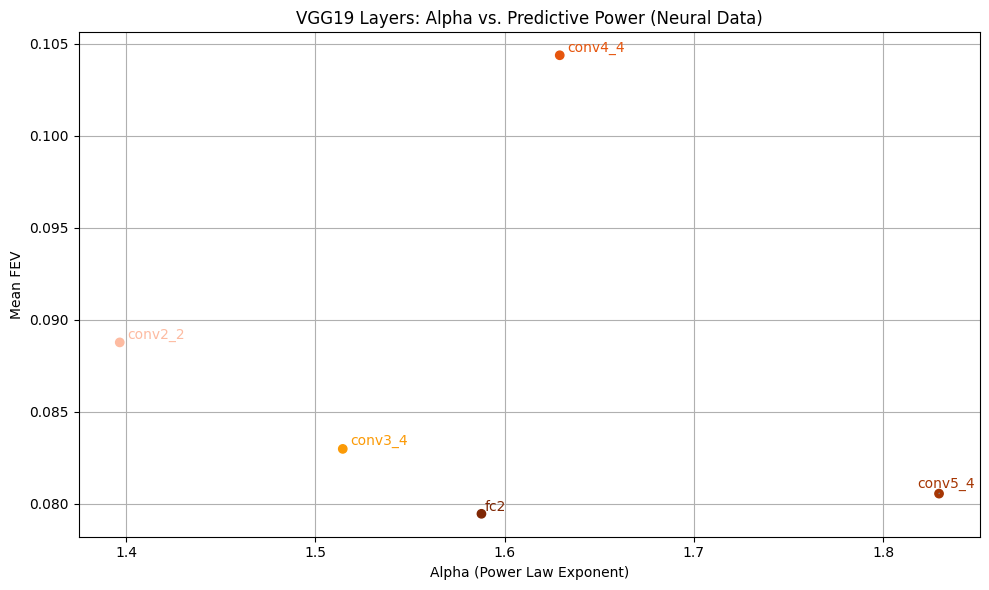

In [8]:
colours = merged_results['layer'].map(vgg19_colours)

plt.figure(figsize=(10, 6))
plt.scatter(merged_results['alpha'], merged_results['mean_fev'], c=colours)

texts = []
for _, row in merged_results.iterrows():
    texts.append(
        plt.text(row['alpha'], row['mean_fev'], row['layer'],
                 color=vgg19_colours[row['layer']], fontsize=10)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('Alpha (Power Law Exponent)')
plt.ylabel('Mean FEV')
plt.title('VGG19 Layers: Alpha vs. Predictive Power (Neural Data)')
plt.grid(True)
plt.tight_layout()
plt.show()